<a href="https://colab.research.google.com/github/slz4025/direct_democracy_toy/blob/master/Direct_Democracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct Democracy

## Introduction

Direct democracies allow each member of a society to voice their views to the whole of society.  However, organizing people effectively to have productive discussions becomes more difficult with more people.  People tend to work best if the groups are smaller than ten people (Agile).  

Despite the downfalls of representative democracies in diminishing the voice of those who are non-representatives, it does offer a general structure that collects views and makes decisions--that of the tree structure (hierarchical structure).  

## Proposed System

Therefore, let us consider the following formal system for implementing direct democracy.  With `N` people, let us divide them into smaller and smaller groups in a tree structure with a fixed branching constant such that the leaf nodes have `n` people, where `n <= 10`.  Now, discussion among the people will take place for `T` units of time and some number of rounds, each of length `t`.  Within each round, the participants of each leaf node discuss the particular issue at hand, and then summarize their discussions. In a representative democracy, discussion would continue at the parent nodes.  However, here, we try to maximize discussion at the leaf nodes, and thus minimize discussion at the parent nodes.  Though the summaries are passed up the tree to the parent node, all the summaries that arrive at a parent node are simply further summarized, then passed up again.  At the root node, the global summary should contain the general sense of the discussion that took place at the lower levels and no more. This global summary is then passed to each leaf group, so that its participants can continue to discuss the issue but now with a better knowledge of the global discussion.  In this way, we can use small, feasible discussion sizes, but also allow people to be aware of a large landscape of experience.

Such a system should ideally be used for complex issues, namely issues that cannot simply be broken into sub-parts that can then be discussed by a further division of people.  In order to determine whether such a system is effective for such problems, we offer the following experiment.

## Experiment 

We have an experience map of `g * g`, where units are white or black.  We want to eventually arrive at a solution that changes the experience map such that, perhaps, there is a "road" from `x` to `y`.

Each person has a preference for where they want the road to be, maybe marked as an alpha value at each unit.  Ideally, these preferences are fairly distributed.

They "discuss" their preferences in small groups of size `n` and try to reach a part of a solution.  Their discussion results in a final summary.

At the summary stage, all the summaries are simply added or averaged together.
The global summary is given to each individual/group, who then factor it more and more heavily into their discussion as time reaches closer to the limit.
At the end, we evaluate: we examine the solution and see if it indeed fits the desired constraints.  If so, success.

## Iterations
X 1. Individuals start off with localized preferences (maybe a Gaussian of size `s` at some location `p`).
2. Discussion tries to solve the A meets B problem.  Maybe incorporate experience-terrain features for difficulty.
3. Maybe try to make DirectDemocracy as abstract as possible so it is up to 
the individuals or the problem how it gets solved/discussed/etc.
4. Individuals have more realistic, generated preferences.
5. We use data.  We convert something such as survey/opinion/poll data into some kind of "map" for which a "solution" can be generated.  There must be a reasonable "encoding" and "decoding" scheme.


## Hypotheses
* The ability to converge will likely depend on `T`, how different the people's preferences are to each other, and how much the people's preferences fit into the constraints. Therefore, consider varying these aspects and seeing how they affect the results. Also need to be careful with how we evaluate the solution.  

## TODO
* test it and see what happens

## Vision
This idea follows under the broader category of human-algorithmic ideas that leverage both the power of sophisticated human reasoning and the organizational structure to produce effective "governance" and problem-solving.

How can people self-organize to solve more complex distributed problems using their own innate and sophisticated reasoning abilities *and* the organizational/algorithmic/connectionist power of structure of the presiding system that "governs" how they communicate and act?  How has this been done in the real-world (maybe Facebook, Github, crowd-sourcing, novel types of exchange, other social platforms build some kind of structure)?  How have people studied them?  How have people thought up of new ones that could solve other problems effectively? This could be like studying some traditional systems, but now we have to consider that "nodes/units/neurons" whatever are people.  How do we take into account their abilities?


In [0]:
# imports
from random import shuffle, choice, randint
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import math

In [0]:
# hard constraints
HARD_MAX_GROUP_SIZE = 10                                                        # agile group size
HARD_MIN_GROUP_SIZE = 2                                                         # an exchange of ideas
HARD_MIN_BRANCH_FACTOR = 2                                                      # minimum possible branching factor

# structure constants
TOTAL_TIME = 1000                                                               # total length of discussion
ROUND_TIME = 10                                                                 # length of discussion round
ROUND_NUM = TOTAL_TIME // ROUND_TIME                                            # number of discussion rounds
TOTAL_IND = 100                                                                # total number of people
GROUP_SIZE = 6                                                                  # size of discussion group
MIN_GROUP_SIZE = 3                                                              # used min group size
BRANCH_FACTOR = 3                                                               # branching constant
MIN_BRANCH_FACTOR = 2                                                           # minimum branching constant

# experiment constants
GRID_SIZE = 10                                                                  # size of experience map
START_PATH = (1,8)                                                              # start position of road
END_PATH = (8,2)                                                                # end position of road
CONSTRAINT_EDIT = 17                                                            # constraint: number of edits to experience to get solution
ACTIVATION_THRESHOLD = 0.5 # TODO currently unbounded, may use clipping
ACTIVATION_MIN = 0.25 # TODO currently unbounded, may use clipping
LOCALIST_SPREAD = 2 # gaussian spread of connectivity
LOCALIST_SIGMA = 1.0 # gaussian sigma of connectivity

# check constants are valid
assert(GRID_SIZE > 0)
assert(GROUP_SIZE <= HARD_MAX_GROUP_SIZE)
assert(MIN_GROUP_SIZE >= HARD_MIN_GROUP_SIZE)
assert(MIN_GROUP_SIZE <= GROUP_SIZE)
assert(MIN_BRANCH_FACTOR <= HARD_MIN_BRANCH_FACTOR)
x = START_PATH
y = END_PATH
assert(x[0] >= 0 and x[0] < GRID_SIZE and x[1] >= 0 and x[1] < GRID_SIZE)
assert(y[0] >= 0 and y[0] < GRID_SIZE and y[1] >= 0 and y[1] < GRID_SIZE)

In [0]:
# helper functions

def show_array(A):
  data = np.uint8(A * 255)
  #https://stackoverflow.com/questions/33828780/matplotlib-display-array-values-with-imshow
  fig = plt.figure(figsize=(4, 3))
  ax = fig.add_subplot(111)
  im = ax.imshow(data, origin='lower', \
    interpolation='None', cmap='gray', vmin=0,vmax=255)
  plt.show()

def flatten(L): # one-level, can make recursive
  S = [e for l in L for e in l]
  return S

def min_max_norm(A): # [0,1]
  num = A - np.min(A)
  den =  np.max(A) - np.min(A)
  if den == 0: return num
  return num / den

In [0]:
# NOTE: Precompute rings and neighbor dict, first indexed by node and then by
# the neighbor, needed to efficiently determine the connectivity
# from START_PATH to END_PATH.
def neighbors(pos):
  i,j = pos
  N = [(i_,j) for i_ in range(i-1,i+2,2) if i_ >= 0 and i_ < GRID_SIZE] \
    + [(i,j_) for j_ in range(j-1,j+2,2) if j_ >= 0 and j_ < GRID_SIZE]
  return N

In [0]:
# commonly seen objects

# terrain
experience_map = np.zeros((GRID_SIZE, GRID_SIZE))
experience_map[START_PATH] = 1.0 
experience_map[END_PATH] = 1.0

# useful
POSITIONS = \
  flatten([[(i,j) for j in range(GRID_SIZE)] for i in range(GRID_SIZE)])
NEIGHBORS = {p:set(neighbors(p)) for p in POSITIONS}

# 2D distance
def distance(p1, p2):
  return math.sqrt(math.pow(p1[0] - p2[0], 2) + math.pow(p1[1] - p2[1], 2))

DISTANCES = {}
for i in range(len(POSITIONS)):
  DISTANCES[POSITIONS[i]] = {} 
for i in range(len(POSITIONS)):
  pos1 = POSITIONS[i]
  for j in range(i, len(POSITIONS)):
    pos2 = POSITIONS[j]
    dist = distance(pos1, pos2)
    # pos1 may == pos2
    DISTANCES[pos1][pos2] = dist
    DISTANCES[pos2][pos1] = dist

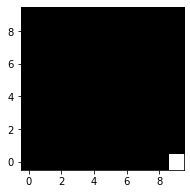

In [0]:
# preference functions to choose among

# https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gkern(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum() # normalize

def gaussian_preference():
  sigma = 1.0
  width = randint(1, 3)
  max_pos = GRID_SIZE - width
  kernel = gkern(width, sigma)
  # position kernel by upper-left corner
  x0 = randint(0, max_pos)
  y0 = randint(0, max_pos)
  preference = np.zeros((GRID_SIZE, GRID_SIZE))
  preference[x0:x0+width,y0:y0+width] = kernel # add in kernel
  # random Gaussian on map
  return preference

def simple_preference(): # do just a spot
  spot = choice(POSITIONS)
  preference = np.zeros((GRID_SIZE, GRID_SIZE))
  preference[spot] = 1.0
  return preference
  
# test
example_preference = simple_preference()
show_array(example_preference)

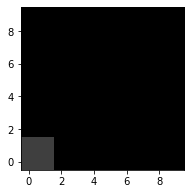

In [0]:
# summarize functions to choose among

def summarize_average(summaries):
  summary = np.mean(np.stack(summaries, axis=0), axis=0)
  return summary

# test
test_arr1 = np.zeros((GRID_SIZE, GRID_SIZE))
test_arr1[0,0] = 1.0
test_arr2 = np.zeros((GRID_SIZE, GRID_SIZE))
test_arr2[1,0] = 1.0
test_arr3 = np.zeros((GRID_SIZE, GRID_SIZE))
test_arr3[0,1] = 1.0
test_arr4 = np.zeros((GRID_SIZE, GRID_SIZE))
test_arr4[1,1] = 1.0
test_arrs = [test_arr1, test_arr2, test_arr3, test_arr4]
test_array = summarize_average(test_arrs)
show_array(test_array)

In [0]:
# evaluate discussion

def evaluate(solution_map):
  show_array(solution_map)

contribution


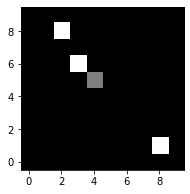

In [0]:
# class to govern how an individual works
class Individual:

  def __init__(self, preference_func):
    # TODO temporary turn-off
    self.preference = np.zeros((GRID_SIZE, GRID_SIZE))
    #self.preference = preference_func() # run the function to generate a map

  # want strongest point to be at a spot that is roughly the meeting point
  # of all others
  def add_spot(self, discussion):
    contribution = np.zeros((GRID_SIZE, GRID_SIZE))

    # goal is most important
    # tendency to blob vs go in a path...
    # maybe need a new way to think this...
    # need a way to encourage more vine-like growth vs blob-like growth
    # also need to be wary of contributions vs targets...
    # solve this normally (given less of prefs, targets)
    # then solve it in round-robin fashion... 
    # also worried that summary vs more discussion could have impact...
    # really depends on how each person addresses it... :///
    # think more about how people would actually solve this
    # maybe each person SHOULD propose their own path (roughly)
    # then they find union, and then determine which spots are best...
    # so, NO round-robin, instead do this in a more actual discussion form...


    """ BLOB distance pos power
    hotspots = np.clip((discussion + self.preference) * 0.5 + experience_map, 0.0, 1.0)

    # get position that has MINIMUM cumulative distance from hotspots
    distance = np.zeros((GRID_SIZE, GRID_SIZE))
    for i in range(len(POSITIONS)):
      score = 0.0
      pos1 = POSITIONS[i]
      for j in range(len(POSITIONS)):
        pos2 = POSITIONS[j]
        if pos1 == pos2: continue
        score += hotspots[pos2] * DISTANCES[pos1][pos2]
      distance[pos1] = score

    distance = min_max_norm(distance)
    distance = distance < 0.1 # makes "dark" signal stronger
    distance = distance - hotspots
    distance = np.clip(distance, 0.0, None)

    dist_sum = np.sum(distance)
    if dist_sum > 0.0:
      distance /= dist_sum
    else:
      print("ERROR: non-positive difference-sum")
      return contribution #nothing
    prob_dist = [distance[p] for p in POSITIONS]
    #print("prob_dist", prob_dist)
    pos_index = np.random.choice(GRID_SIZE * GRID_SIZE, 1, p = prob_dist)[0]
    pick = POSITIONS[pos_index]
    
    contribution[pick] = 1.0 
    """

    """ distance neg power
    # find which spots are more advantageous
    connectivity = np.zeros((GRID_SIZE, GRID_SIZE))
    for i in range(len(POSITIONS)):
      score = 0.0
      pos1 = POSITIONS[i]
      for j in range(len(POSITIONS)):
        pos2 = POSITIONS[j]
        if pos1 == pos2: continue
        score += hotspots[pos2] / DISTANCES[pos1][pos2]
      connectivity[pos1] = score

    # calculate probability distribution
    difference = min_max_norm(connectivity) - min_max_norm(discussion)
    #options = np.where(difference == np.max(difference))
    #pick = choice(list(zip(options[0], options[1])))
    # get rid of negatives: these values are ones that are strong enough
    difference = np.clip(difference, 0.0, None)
    #difference = np.power(difference, 2) # strengthen signal at high activated
    print("difference")
    show_array(difference)
    diff_sum = np.sum(difference)
    if diff_sum > 0.0:
      difference /= diff_sum
    else:
      print("ERROR: non-positive difference-sum")
      return contribution #nothing
    prob_dist = [difference[p] for p in POSITIONS]

    # pick based off of difference probability distribution
    pos_index = np.random.choice(GRID_SIZE * GRID_SIZE, 1, p = prob_dist)[0]
    pick = POSITIONS[pos_index]
    
    contribution[pick] = 1.0 
    """

    return contribution

  def remove_spot(self, discussion):
    # take out a subset of those that are less than ACTIVATION_MIN
    contribution = np.zeros((GRID_SIZE, GRID_SIZE))
    #min_indices = np.where(discussion == np.min(discussion, \
    #  where = (discussion > ACTIVATION_MIN), initial = np.inf))
    #min_indices = list(zip(min_indices[0], min_indices[1]))
    #pick = choice(min_indices)
    #contribution[pick] = -1.0
    lesser = np.where(discussion < ACTIVATION_MIN)
    # make sure total weight of contribution is -1
    contribution -lesser / np.sum(lesser)
    return contribution

  def speak(self, discussion):
    condition = np.sum(discussion) >= CONSTRAINT_EDIT # too many!
    if condition:
      contribution = self.remove_spot(discussion)
    else:
      contribution = self.add_spot(discussion)
    return contribution

I = Individual(simple_preference) 
input_map = np.copy(experience_map)
input_map[6,3] = 1.0
C = I.add_spot(input_map)
print("contribution")
show_array(C * 0.5 + input_map)

In [0]:
class Group:
  def __init__(self, members):
    self.members = members
    self.speaker = randint(0, len(self.members) - 1)

  def discuss(self, summary):#, summary_weight):
    #contribution_weight = (1.0 - summary_weight)
    contribution = self.members[self.speaker].speak(summary)
    #summary = np.clip(summary + contribution * contribution_weight * 0.5, 0.0, 1.0)
    # TODO need to make sure we do overpower existiing stuff
    # add back START and END, TODO 0.9 being decay hyperparam
    
    # DECAY param
    summary = np.clip(summary * 0.9 + contribution * 0.1, 0.0, 1.0 )
    self.speaker = (self.speaker + 1) % len(self.members) # round robin for now
    return summary

In [0]:
# main

individuals = []
for i in range(GROUP_SIZE):
  individual = Individual(simple_preference)
  #print("Individual {}\n".format(i))
  #show_array(individual.preference)
  individuals.append(individual)

unit = Group(individuals)

#weight = 0.5
#weight_update = weight / float(TOTAL_TIME)
summary = np.copy(experience_map)

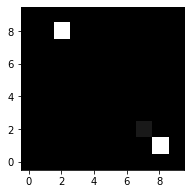

-------------------------------


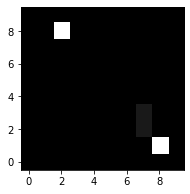

-------------------------------


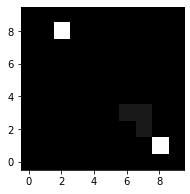

-------------------------------


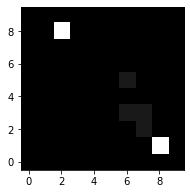

-------------------------------


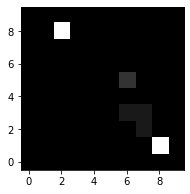

-------------------------------


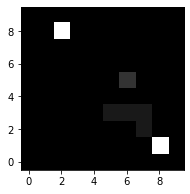

-------------------------------


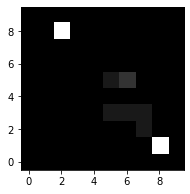

-------------------------------


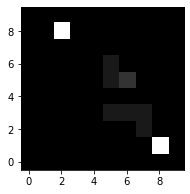

-------------------------------


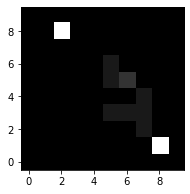

-------------------------------


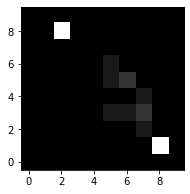

-------------------------------


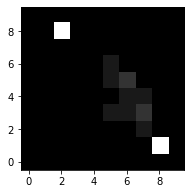

-------------------------------


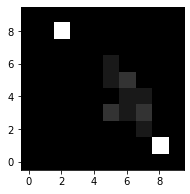

-------------------------------


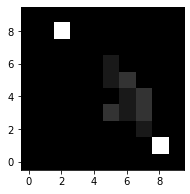

-------------------------------


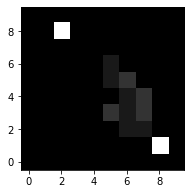

-------------------------------


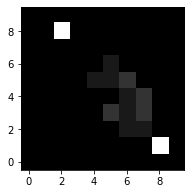

-------------------------------


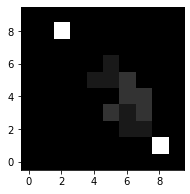

-------------------------------


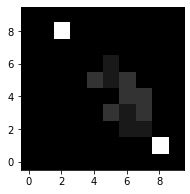

-------------------------------


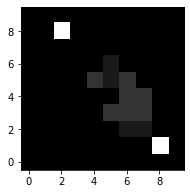

-------------------------------


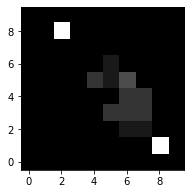

-------------------------------


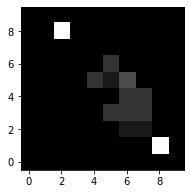

-------------------------------


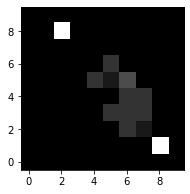

-------------------------------


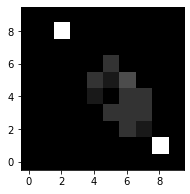

-------------------------------


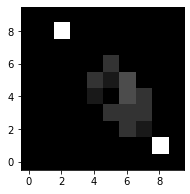

-------------------------------


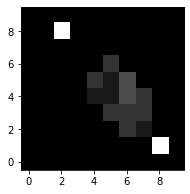

-------------------------------


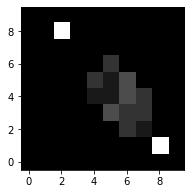

-------------------------------


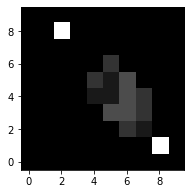

-------------------------------


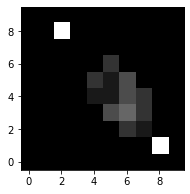

-------------------------------


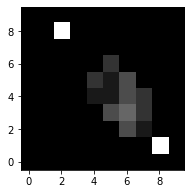

-------------------------------


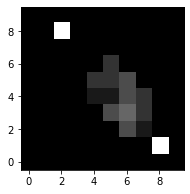

-------------------------------


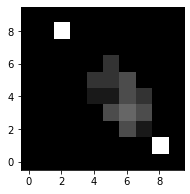

-------------------------------


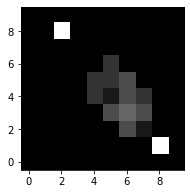

-------------------------------


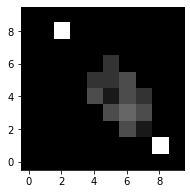

-------------------------------


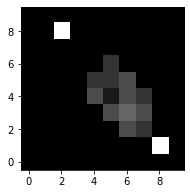

-------------------------------


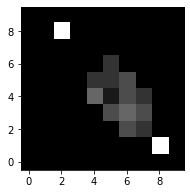

-------------------------------


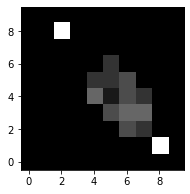

-------------------------------


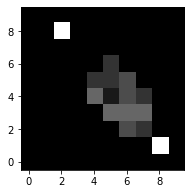

-------------------------------


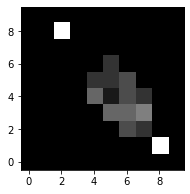

-------------------------------


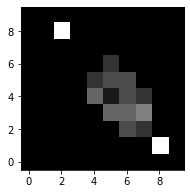

-------------------------------


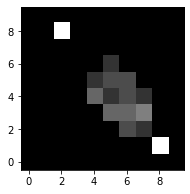

-------------------------------


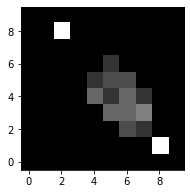

-------------------------------


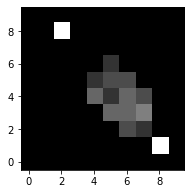

-------------------------------


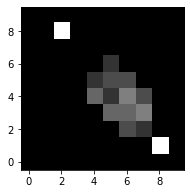

-------------------------------


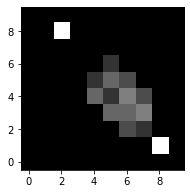

-------------------------------


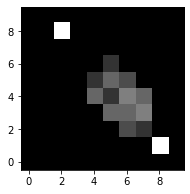

-------------------------------


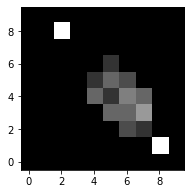

-------------------------------


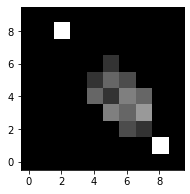

-------------------------------


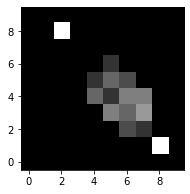

-------------------------------


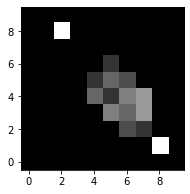

-------------------------------


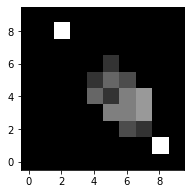

-------------------------------


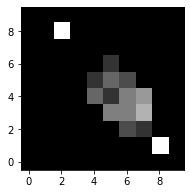

-------------------------------


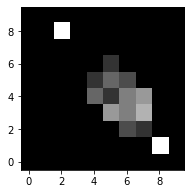

-------------------------------


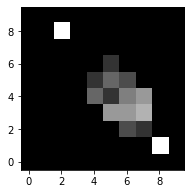

-------------------------------


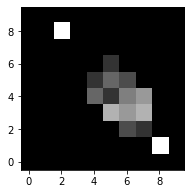

-------------------------------


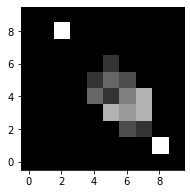

-------------------------------


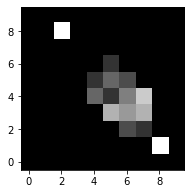

-------------------------------


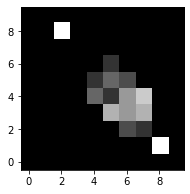

-------------------------------


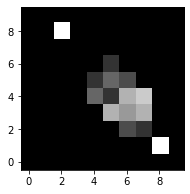

-------------------------------


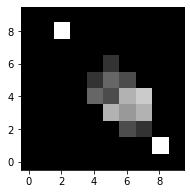

-------------------------------


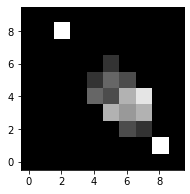

-------------------------------


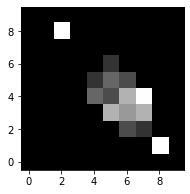

-------------------------------


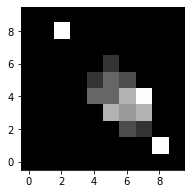

-------------------------------


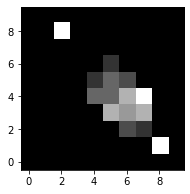

-------------------------------


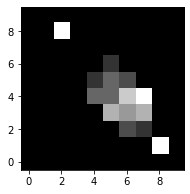

-------------------------------


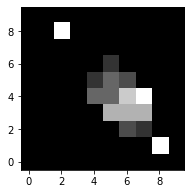

-------------------------------


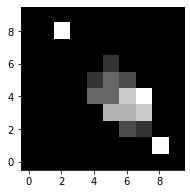

-------------------------------


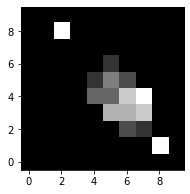

-------------------------------


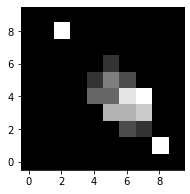

-------------------------------


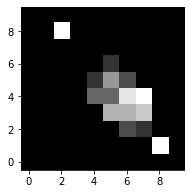

-------------------------------


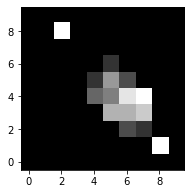

-------------------------------


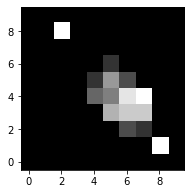

-------------------------------


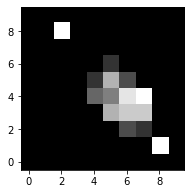

-------------------------------


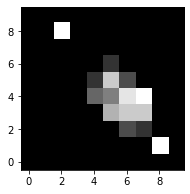

-------------------------------


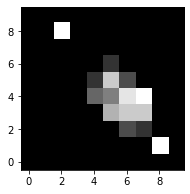

-------------------------------


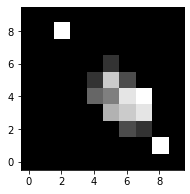

-------------------------------


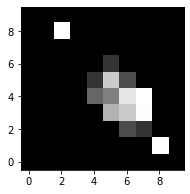

-------------------------------


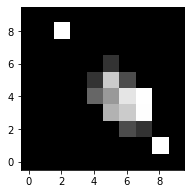

-------------------------------


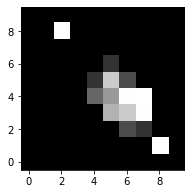

-------------------------------


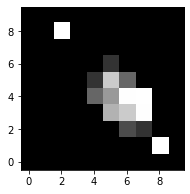

-------------------------------


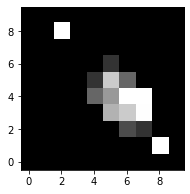

-------------------------------


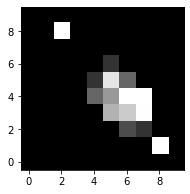

-------------------------------


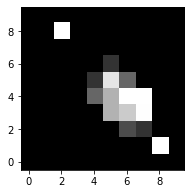

-------------------------------


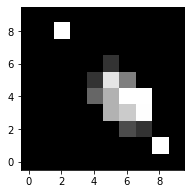

-------------------------------


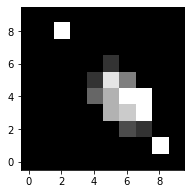

-------------------------------


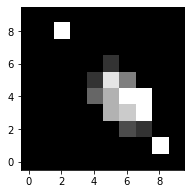

-------------------------------


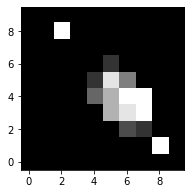

-------------------------------


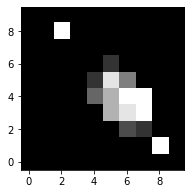

-------------------------------


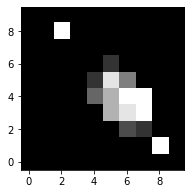

-------------------------------


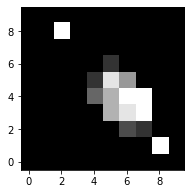

-------------------------------


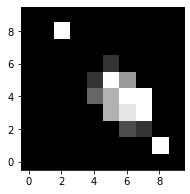

-------------------------------


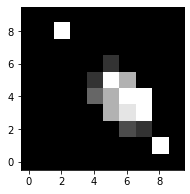

-------------------------------


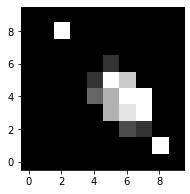

-------------------------------


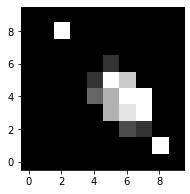

-------------------------------


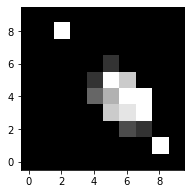

-------------------------------


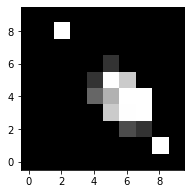

-------------------------------


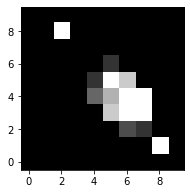

-------------------------------


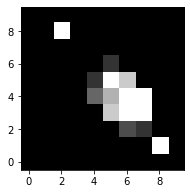

-------------------------------


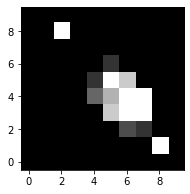

-------------------------------


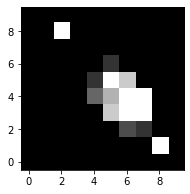

-------------------------------


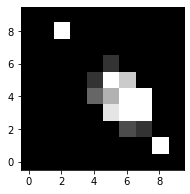

-------------------------------


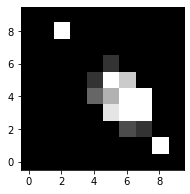

-------------------------------


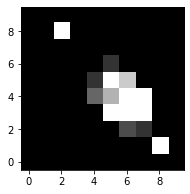

-------------------------------


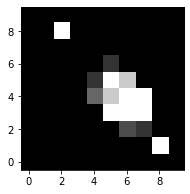

-------------------------------


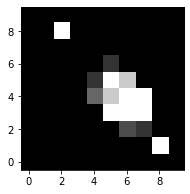

-------------------------------


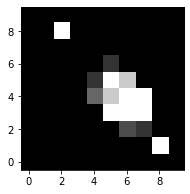

-------------------------------


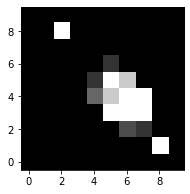

-------------------------------


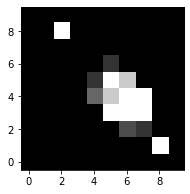

-------------------------------


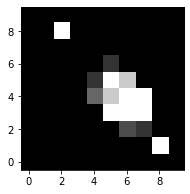

-------------------------------


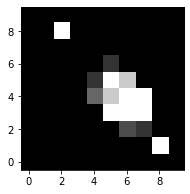

-------------------------------


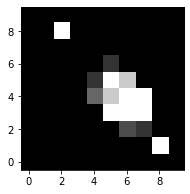

-------------------------------


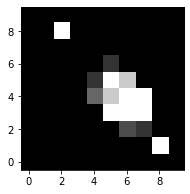

-------------------------------


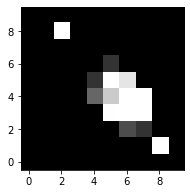

-------------------------------


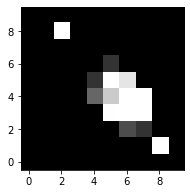

-------------------------------


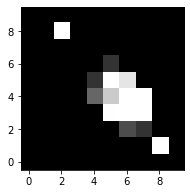

-------------------------------


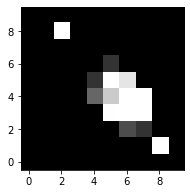

-------------------------------


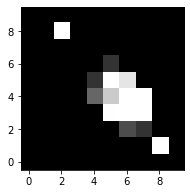

-------------------------------


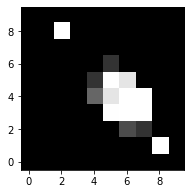

-------------------------------


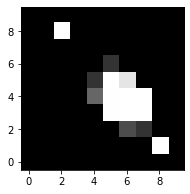

-------------------------------


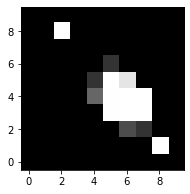

-------------------------------


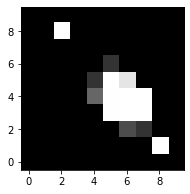

-------------------------------


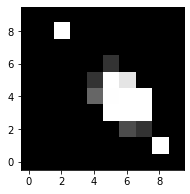

-------------------------------


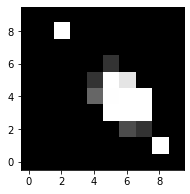

-------------------------------


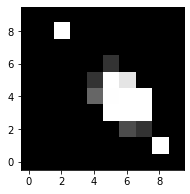

-------------------------------


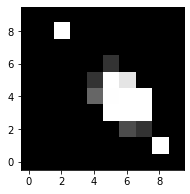

-------------------------------


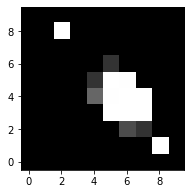

-------------------------------


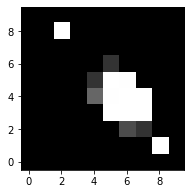

-------------------------------


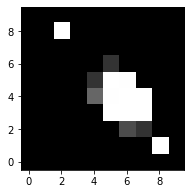

-------------------------------


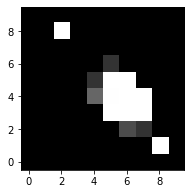

-------------------------------


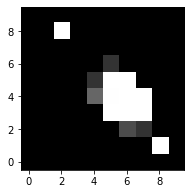

-------------------------------


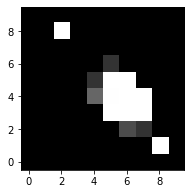

-------------------------------


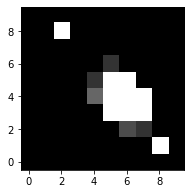

-------------------------------


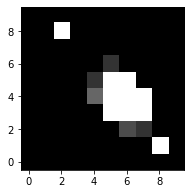

-------------------------------


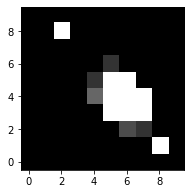

-------------------------------


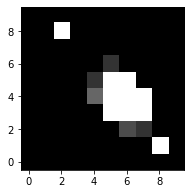

-------------------------------


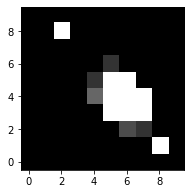

-------------------------------


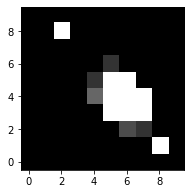

-------------------------------


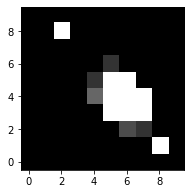

-------------------------------


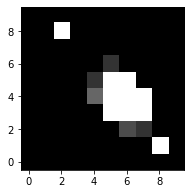

-------------------------------


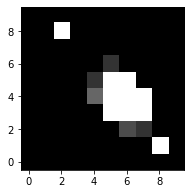

-------------------------------


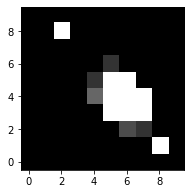

-------------------------------


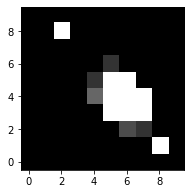

-------------------------------


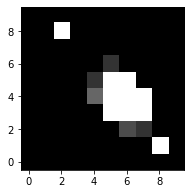

-------------------------------


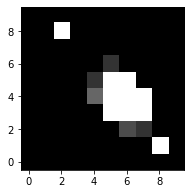

-------------------------------


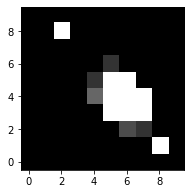

-------------------------------


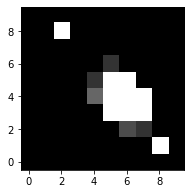

-------------------------------


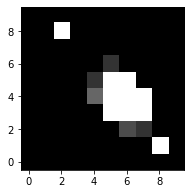

-------------------------------


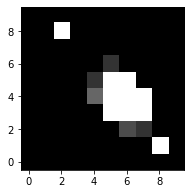

-------------------------------


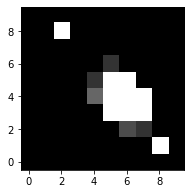

-------------------------------


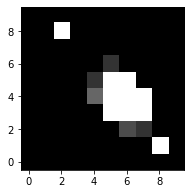

-------------------------------


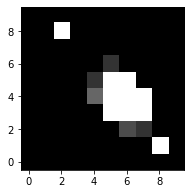

-------------------------------


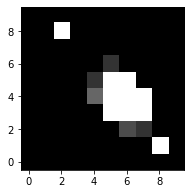

-------------------------------


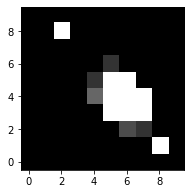

-------------------------------


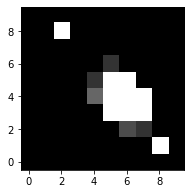

-------------------------------


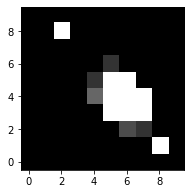

-------------------------------


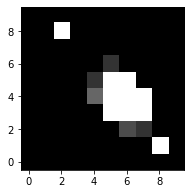

-------------------------------


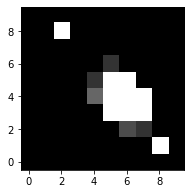

-------------------------------


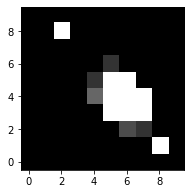

-------------------------------


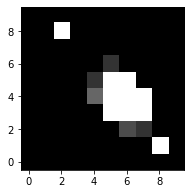

-------------------------------


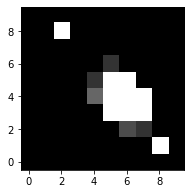

-------------------------------


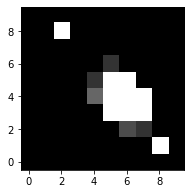

-------------------------------


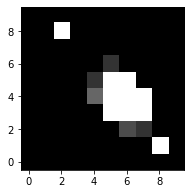

-------------------------------


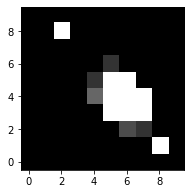

-------------------------------


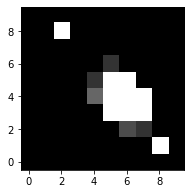

-------------------------------


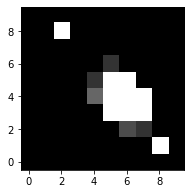

-------------------------------


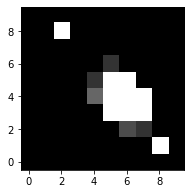

-------------------------------


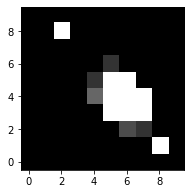

-------------------------------


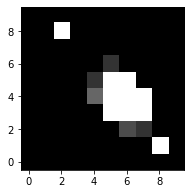

-------------------------------


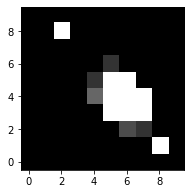

-------------------------------


KeyboardInterrupt: ignored

In [0]:
for i in range(TOTAL_TIME):
  summary = unit.discuss(summary) #, weight)
  #weight += weight_update
  show_array(summary)
  print("-------------------------------")

In [0]:
class LeafGroup:
  def __init__(self, members, parent):
    self.parent = parent
    self.members = members

  # this is where the ROUND_TIME matters
  def discuss(self, global_summary, global_summary_weight):
    discussion = np.copy(global_summary)
    # !!! the contributive value of each person
    contribution_weight = (1.0 - global_summary_weight) / float(ROUND_TIME)
    # choose random person to start with, then go in order
    speaker = randint(0, len(self.members) - 1)
    for i in range(ROUND_TIME):
      discussion = self.members[speaker].speak(discussion, contribution_weight)
      speaker = (speaker + 1) % len(self.members)
    discussion_summary = discussion # simple
    return discussion_summary

  def summarize(self, global_summary, global_summary_weight):
    # don't need summarize_func_type
    discussion_summary = self.discuss(global_summary, global_summary_weight)
    # [?] processing
    return discussion_summary

In [0]:
class ParentGroup:
  def __init__(self, members, parent, summarize_func):
    self.parent = parent
    self.children = []
    
    assert(len(members) > GROUP_SIZE)
    assert(len(members) >= MIN_BRANCH_FACTOR * MIN_GROUP_SIZE)
    branch_factor = BRANCH_FACTOR
    children_size = len(members) // branch_factor
    if children_size > GROUP_SIZE: # children are parents
      while (len(members) > 2 * children_size):
        group = members[:children_size]
        members = members[children_size:]
        self.children.append(ParentGroup(group, self, summarize_func))
      assert(len(members) >= children_size)
      self.children.append(ParentGroup(members, self, summarize_func))
    else: # children are leaves
      if children_size <= MIN_GROUP_SIZE:
        branch_factor = len(members) // MIN_GROUP_SIZE
        children_size = len(members) // branch_factor # may != MIN_GROUP_SIZE
        # consider 16 // 6 = 2, 16 // 2 = 8
      while (len(members) >= 2 * children_size):
        group = members[:children_size]
        members = members[children_size:]
        self.children.append(LeafGroup(group, self))
      assert(len(members) >= children_size)
      self.children.append(LeafGroup(members, self))
  
  def summarize(self, global_summary, global_summary_weight):
    summaries = [c.summarize(global_summary, global_summary_weight) \
      for c in self.children]
    summary = summarize_average(summaries)

    return summary

In [0]:
# class for the proposed direct democracy structure
class DirectDemocracy:

  def __init__(self, summary_func, members, round_num, base_map):
    shuffle(members) # random
    self.root_group = ParentGroup(members, None, summary_func)
    self.global_summary_weight = 0.5
    self.global_summary_weight_update = \
      self.global_summary_weight / float(round_num)
    self.global_summary = np.copy(base_map) # to start

  def run_round(self):
    summary = self.root_group.summarize(
      self.global_summary, self.global_summary_weight)
    self.global_summary_weight += self.global_summary_weight_update # linear
    return summary # change

The below is to run a small group, which is the basic or minimized unit of any democratic model.

The below is to run the Direct Democracy model.

In [0]:
# main

# create individuals with preferences
individuals = []
for i in range(TOTAL_IND):
  individual = Individual(simple_preference)
  #print("Individual {}\n".format(i))
  #show_array(individual.preference)
  individuals.append(individual)

# organize individuals into groups
dd = DirectDemocracy(summarize_average, individuals, ROUND_NUM, experience_map)

In [0]:
global_summary = dd.run_round()
show_array(global_summary)

In [0]:
# run each round
for i in range(ROUND_NUM):
  global_summary = dd.run_round()
  if i % 100 == 0:
    show_array(global_summary)